# CA 3 - Image Classification with CNN

## Importing the Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout

## Downloading the dataset
Run the next block only if using on Google Colab.
A special file kaggle.json needs to be in the runtime for the next code to run. It contains kaggle API credentials. It can be downloaded from Kaggle.com

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia
!unzip chest-xray-covid19-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/train/COVID19/COVID19(228).jpg  
  inflating: Data/train/COVID19/COVID19(229).jpg  
  inflating: Data/train/COVID19/COVID19(23).jpg  
  inflating: Data/train/COVID19/COVID19(230).jpg  
  inflating: Data/train/COVID19/COVID19(231).jpg  
  inflating: Data/train/COVID19/COVID19(232).jpg  
  inflating: Data/train/COVID19/COVID19(233).jpg  
  inflating: Data/train/COVID19/COVID19(234).jpg  
  inflating: Data/train/COVID19/COVID19(235).jpg  
  inflating: Data/train/COVID19/COVID19(236).jpg  
  inflating: Data/train/COVID19/COVID19(237).jpg  
  inflating: Data/train/COVID19/COVID19(238).jpg  
  inflating: Data/train/COVID19/COVID19(239).jpg  
  inflating: Data/train/COVID19/COVID19(24).jpg  
  inflating: Data/train/COVID19/COVID19(240).jpg  
  inflating: Data/train/COVID19/COVID19(241).jpg  
  inflating: Data/train/COVID19/COVID19(242).jpg  
  inflating: Data/train/COVID19/COVID19(243).jpg  
  inflating: Data/train/COVID19/C

The data set is divided into 2 sets:

1. Train set
2. Test set

These further hold images of X-ray from healthy patients and patients with Pneumonia or Covid-19 in their respective subfolders.

In [4]:
os.listdir('./Data/train')

['COVID19', 'NORMAL', 'PNEUMONIA']

## Quantitative Analysis of Images

-------------------Train Set-------------------
Normal: 1266
Covid19: 460
Pneumonia: 3418
Total:  5144
-------------------Test Set-------------------
Normal: 317
Covid19: 116
Pneumonia: 855
Total:  1288




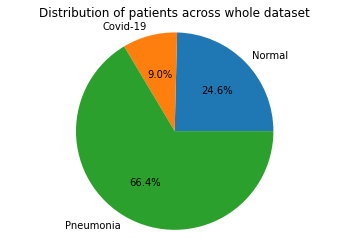

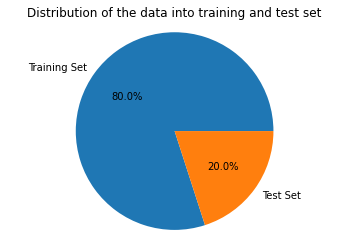

In [5]:
# Getting the total image count
trainNormalCount = len(os.listdir('./Data/train/NORMAL'))
trainCovidCount = len(os.listdir('./Data/train/COVID19'))
trainPneumoniaCount = len(os.listdir('./Data/train/PNEUMONIA'))  
trainTotal = trainNormalCount + trainCovidCount + trainPneumoniaCount

testNormalCount = len(os.listdir('./Data/test/NORMAL'))
testCovidCount = len(os.listdir('./Data/test/COVID19'))  
testPneumoniaCount = len(os.listdir('./Data/test/PNEUMONIA'))
testTotal = testNormalCount + testCovidCount + testPneumoniaCount

print("-------------------Train Set-------------------")
print("Normal:", trainNormalCount)
print("Covid19:", trainCovidCount)
print("Pneumonia:", trainPneumoniaCount)
print("Total: ", trainTotal)

print("-------------------Test Set-------------------")
print("Normal:", testNormalCount)
print("Covid19:", testCovidCount)
print("Pneumonia:", testPneumoniaCount)
print("Total: ", testTotal)


# Plotting pie-charts for population distribution
# 1) Distribution of Classes
print("\n")
labels = 'Normal', 'Covid-19', 'Pneumonia'
sizes = [(trainNormalCount + testNormalCount), (trainCovidCount + testCovidCount), (trainPneumoniaCount + testPneumoniaCount)]

fig, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct='%1.1f%%')
ax1.set_title('Distribution of patients across whole dataset')
ax1.axis('equal')

plt.show()

# 2) Distribution of set
print("\n")
labels = 'Training Set', 'Test Set'
sizes = [trainTotal, testTotal]

fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels = labels, autopct='%1.1f%%')
ax2.set_title("Distribution of the data into training and test set")
ax2.axis('equal')

plt.show()

As we can see the dataset is already divided into training and test set with a split of 80:20.  
We are planning for cross-validation hence we also need a validation set. The split ratio in that case is 70:20:10 respectively for training, validation and test set.
We can split 10% of data needed for test set from training set and then use the original test set with 20% to validation set.

## Qualitative Analysis of Images

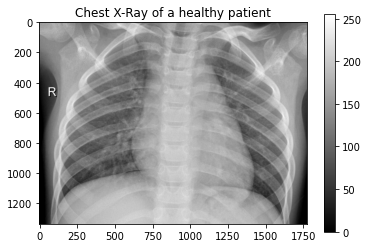


The image dimensions are: 
Width = 1337 pixels
Height = 1777 pixels

Pixels descripton: 
Maximum Value = 255
Minimum Value = 0
Mean Value = 146.76173864584828
Standard Deviation = 45.26262018750923


In [6]:
# Taking a X-ray image of a healthy patient
imageLoc = './Data/train/NORMAL'
imageName = os.listdir('./Data/train/NORMAL')[0]
sampleImage = plt.imread(os.path.join(imageLoc, imageName))

# Plotting the image
plt.imshow(sampleImage, cmap = 'gray')
plt.colorbar()
plt.title("Chest X-Ray of a healthy patient")
plt.show()

# Image Dimensions
print(f"\nThe image dimensions are: \nWidth = {sampleImage.shape[0]} pixels\nHeight = {sampleImage.shape[1]} pixels")
print(f"\nPixels descripton: \nMaximum Value = {sampleImage.max()}\nMinimum Value = {sampleImage.min()}\nMean Value = {sampleImage.mean()}\nStandard Deviation = {sampleImage.std()}")

## Preparing Data for Model

In [7]:
# Loading and splitting the dataset into training, validation and test set
trainDir = './Data/train'
testDir = './Data/test'

# ImageDataGenerator class allows us to load from the disk, split the dataset and apply data augmentation
imageGenerator = ImageDataGenerator(samplewise_std_normalization = True, samplewise_center = True, rescale = 1./255,
                                    rotation_range=20, width_shift_range=0.1, shear_range=0.1, 
                                    zoom_range=0.1, validation_split = 0.125)

# Load the data from local to the code
train = imageGenerator.flow_from_directory(trainDir, batch_size = 10, shuffle = True, subset = 'training', 
                                           class_mode = 'categorical', target_size = (224,224))
test = imageGenerator.flow_from_directory(trainDir, batch_size = 1, shuffle = False, subset = 'validation', 
                                          class_mode = 'categorical', target_size = (224,224))
valid = imageGenerator.flow_from_directory(testDir, batch_size = 1, shuffle = False, 
                                           class_mode = 'categorical', target_size = (224,224))



Found 4502 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


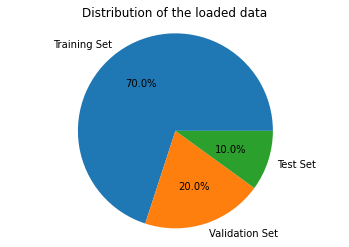

In [8]:
# From the output above we can use number of images to see if the split is done correctly
labels = 'Training Set','Validation Set','Test Set'
sizes = [4502, 1288, 642]

fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels = labels, autopct='%1.1f%%')
ax2.set_title("Distribution of the loaded data")
ax2.axis('equal')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


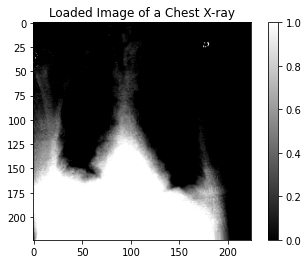


The image dimensions are: 
Width = 224 pixels
Height = 224 pixels

Pixels descripton: 
Maximum Value = 1.541033148765564
Minimum Value = -1.789185643196106
Mean Value = -1.1353265705338345e-07
Standard Deviation = 0.9999966025352478


In [9]:
# Analyse a loaded image
loadedImageBatch, classLabel = train.__getitem__(0)
loadedImage = loadedImageBatch[0]
plt.imshow(loadedImage, cmap = 'gray')
plt.colorbar()
plt.title("Loaded Image of a Chest X-ray")
plt.show()

print(f"\nThe image dimensions are: \nWidth = {loadedImage.shape[0]} pixels\nHeight = {loadedImage.shape[1]} pixels")
print(f"\nPixels descripton: \nMaximum Value = {loadedImage.max()}\nMinimum Value = {loadedImage.min()}\nMean Value = {loadedImage.mean()}\nStandard Deviation = {loadedImage.std()}")

## Model Training

### ResNet50V2 Training

In [9]:
resnet = ResNet50V2(input_shape = loadedImage.shape, include_top = False, weights = 'imagenet')

# Freezing weights of all the reused layers
for layer in resnet.layers:
    layer.trainable = False

94683136/94668760 [==============================] - 0s 0us/step


In [10]:
# Adding output layers to ResNet50V2 according to its architecture
x = GlobalAveragePooling2D()(resnet.output)
predictions = Dense(3, activation = 'softmax')(x)

modelResNet = Model(inputs = resnet.input, outputs = predictions)
modelResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
#Compiling and training the model
modelResNet.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyResNet = modelResNet.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
451/451 [==============================] - 204s 423ms/step - loss: 0.4343 - accuracy: 0.8234 - val_loss: 0.2381 - val_accuracy: 0.9022
Epoch 2/10
451/451 [==============================] - 187s 416ms/step - loss: 0.2724 - accuracy: 0.8960 - val_loss: 0.2382 - val_accuracy: 0.9022
Epoch 3/10
451/451 [==============================] - 192s 427ms/step - loss: 0.2610 - accuracy: 0.8952 - val_loss: 0.2626 - val_accuracy: 0.8952
Epoch 4/10
451/451 [==============================] - 190s 421ms/step - loss: 0.2413 - accuracy: 0.9098 - val_loss: 0.2133 - val_accuracy: 0.9185
Epoch 5/10
451/451 [==============================] - 190s 421ms/step - loss: 0.2367 - accuracy: 0.9100 - val_loss: 0.1985 - val_accuracy: 0.9247
Epoch 6/10
451/451 [==============================] - 187s 414ms/step - loss: 0.2129 - accuracy: 0.9245 - val_loss: 0.1933 - val_accuracy: 0.9348
Epoch 7/10
451/451 [==============================] - 187s 416ms/step - loss: 0.2276 - accuracy: 0.9176 - val_loss: 0.1996 -

### ResNet50V2 Evaluation

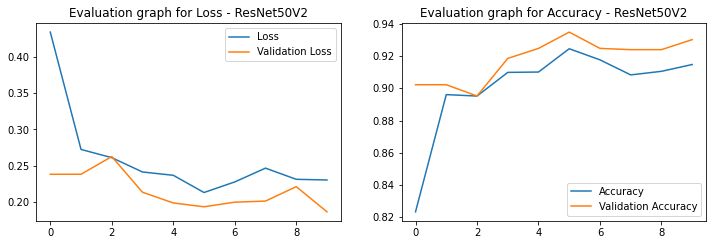

In [12]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyResNet.history['loss'], label = 'Loss')
plt.plot(historyResNet.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Evaluation graph for Loss - ResNet50V2')

plt.subplot(2, 2, 2)
plt.plot(historyResNet.history['accuracy'], label = 'Accuracy')
plt.plot(historyResNet.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Evaluation graph for Accuracy - ResNet50V2')

plt.show()

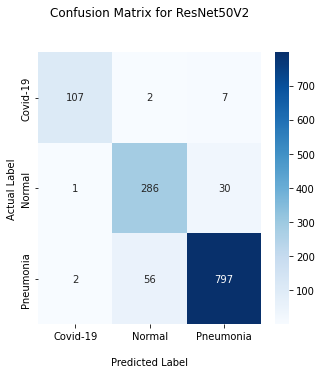


Classification Report for ResNet50V2



,0,1,2,accuracy,macro avg,weighted avg
precision,0.972727,0.831395,0.955635,0.923913,0.919919,0.926597
recall,0.922414,0.902208,0.932164,0.923913,0.918929,0.923913
f1-score,0.946903,0.865356,0.943754,0.923913,0.918671,0.924742
support,116.000000,317.000000,855.000000,0.923913,1288.000000,1288.000000


In [13]:
# Plotting Confusion Matrix and Classification report
predictionValid = modelResNet.predict(valid, steps = len(valid))
confusionMatrix = confusion_matrix(valid.classes, predictionValid.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrix, annot = True, cmap = 'Blues', fmt = 'g')

ax.set_title('Confusion Matrix for ResNet50V2\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Covid-19', 'Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Covid-19', 'Normal', 'Pneumonia'])

plt.show()

print("\nClassification Report for ResNet50V2\n")
pd.DataFrame(classification_report(valid.classes, predictionValid.argmax(axis = 1) , output_dict=True))

### VGGNet16 Training

In [11]:
vgg = VGG16(input_shape = loadedImage.shape, include_top = False, weights = 'imagenet')

# Freezing weights of all the reused layers
for layer in vgg.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [8]:
# Adding output layers to VGGNet16 according to its architecture
flatten = Flatten()(vgg.output)
dense1 = Dense(4096, activation = 'relu')(flatten)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(512, activation = 'relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

predictions = keras.layers.Dense(3, activation = 'softmax')(dropout2)

modelVGG = Model(inputs = vgg.input, outputs = predictions)
modelVGG.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
#Compiling and training the model
modelVGG.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyVGG = modelVGG.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
451/451 [==============================] - 206s 448ms/step - loss: 1.7600 - accuracy: 0.8398 - val_loss: 0.1471 - val_accuracy: 0.9480
Epoch 2/10
451/451 [==============================] - 194s 430ms/step - loss: 0.2865 - accuracy: 0.9185 - val_loss: 0.1481 - val_accuracy: 0.9480
Epoch 3/10
451/451 [==============================] - 193s 427ms/step - loss: 0.2231 - accuracy: 0.9256 - val_loss: 0.1347 - val_accuracy: 0.9472
Epoch 4/10
451/451 [==============================] - 193s 428ms/step - loss: 0.2175 - accuracy: 0.9271 - val_loss: 0.1321 - val_accuracy: 0.9550
Epoch 5/10
451/451 [==============================] - 192s 426ms/step - loss: 0.2364 - accuracy: 0.9245 - val_loss: 0.2110 - val_accuracy: 0.9317
Epoch 6/10
451/451 [==============================] - 193s 428ms/step - loss: 0.2295 - accuracy: 0.9296 - val_loss: 0.1518 - val_accuracy: 0.9348
Epoch 7/10
451/451 [==============================] - 192s 427ms/step - loss: 0.2076 - accuracy: 0.9303 - val_loss: 0.1468 -

### VGGNet16 Evaluation

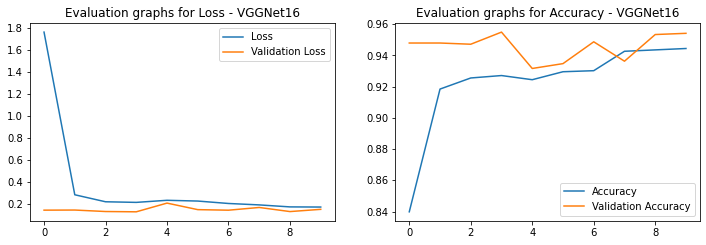

In [10]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyVGG.history['loss'], label='Loss')
plt.plot(historyVGG.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Evaluation graphs for Loss - VGGNet16')

plt.subplot(2, 2, 2)
plt.plot(historyVGG.history['accuracy'], label='Accuracy')
plt.plot(historyVGG.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Evaluation graphs for Accuracy - VGGNet16')

plt.show()

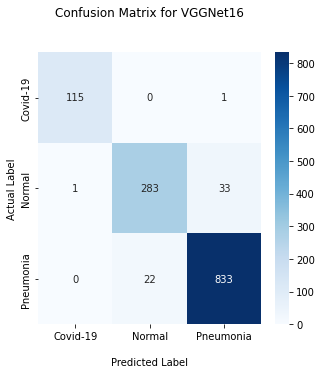


Classification Report for VGGNet16



,0,1,2,accuracy,macro avg,weighted avg
precision,0.991379,0.927869,0.960784,0.955745,0.960011,0.955439
recall,0.991379,0.892744,0.974269,0.955745,0.952798,0.955745
f1-score,0.991379,0.909968,0.967480,0.955745,0.956276,0.955477
support,116.000000,317.000000,855.000000,0.955745,1288.000000,1288.000000


In [11]:
# Plotting Confusion Matrix and Classification report
predictionValid = modelVGG.predict(valid, steps = len(valid))
confusionMatrix = confusion_matrix(valid.classes, predictionValid.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for VGGNet16\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])

plt.show()

print("\nClassification Report for VGGNet16\n")
pd.DataFrame(classification_report(valid.classes, predictionValid.argmax(axis = 1) , output_dict=True))

## Creating a new CNN model

### Training

In [12]:
# The idea is to add more layers of dense and dropout to the VGGNet16 architecture
flatten = Flatten()(vgg.output)
dense1 = Dense(4096, activation = 'relu')(flatten)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(1024, activation = 'relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Adding first layer
dense3 = Dense(256, activation = 'relu')(dropout2)
dropout3 = Dropout(0.5)(dense3)

# Adding second layer
dense4 = Dense(64, activation = 'relu')(dropout3)
dropout4 = Dropout(0.5)(dense4)

predictions = Dense(3, activation = 'softmax')(dropout4)
newModel = Model(inputs = vgg.input, outputs = predictions)
newModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
#Compiling and training the model
newModel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyNewModel = newModel.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
451/451 [==============================] - 236s 496ms/step - loss: 2.5316 - accuracy: 0.6346 - val_loss: 0.2847 - val_accuracy: 0.9123
Epoch 2/10
451/451 [==============================] - 196s 435ms/step - loss: 0.4286 - accuracy: 0.8510 - val_loss: 0.2274 - val_accuracy: 0.9193
Epoch 3/10
451/451 [==============================] - 194s 430ms/step - loss: 0.3337 - accuracy: 0.8896 - val_loss: 0.1759 - val_accuracy: 0.9293
Epoch 4/10
451/451 [==============================] - 193s 429ms/step - loss: 0.3010 - accuracy: 0.9067 - val_loss: 0.1838 - val_accuracy: 0.9363
Epoch 5/10
451/451 [==============================] - 194s 431ms/step - loss: 0.2701 - accuracy: 0.9120 - val_loss: 0.2164 - val_accuracy: 0.9278
Epoch 6/10
451/451 [==============================] - 193s 428ms/step - loss: 0.2281 - accuracy: 0.9316 - val_loss: 0.1588 - val_accuracy: 0.9457
Epoch 7/10
451/451 [==============================] - 196s 434ms/step - loss: 0.2138 - accuracy: 0.9334 - val_loss: 0.1921 -

### Evaluation

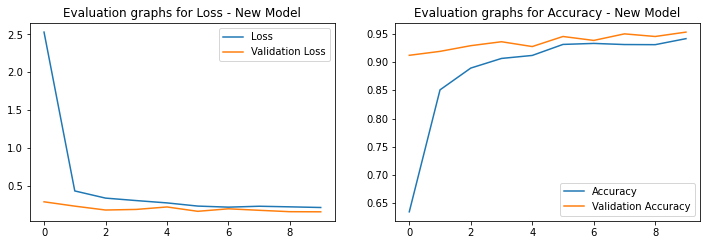

In [14]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyNewModel.history['loss'], label='Loss')
plt.plot(historyNewModel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Evaluation graphs for Loss - New Model')

plt.subplot(2, 2, 2)
plt.plot(historyNewModel.history['accuracy'], label='Accuracy')
plt.plot(historyNewModel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Evaluation graphs for Accuracy - New Model')

plt.show()

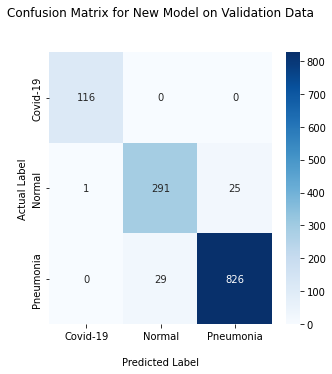


Classification Report for New Model on Validation Data



,0,1,2,accuracy,macro avg,weighted avg
precision,0.966667,0.925566,0.967404,0.957298,0.953212,0.957041
recall,1.000000,0.902208,0.971930,0.957298,0.958046,0.957298
f1-score,0.983051,0.913738,0.969662,0.957298,0.955483,0.957104
support,116.000000,317.000000,855.000000,0.957298,1288.000000,1288.000000


In [18]:
# Plotting Confusion Matrix and Classification report for Validation Data
predictionValid = newModel.predict(valid, steps = len(valid))
confusionMatrixValid = confusion_matrix(valid.classes, predictionValid.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for New Model on Validation Data\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])

plt.show()

print("\nClassification Report for New Model on Validation Data\n")
pd.DataFrame(classification_report(valid.classes, predictionValid.argmax(axis = 1) , output_dict=True))

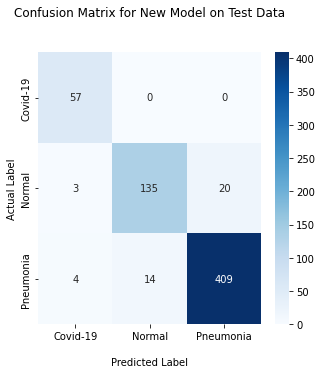


Classification Report for New Model on Test Data



,0,1,2,accuracy,macro avg,weighted avg
precision,0.890625,0.906040,0.953380,0.936137,0.916682,0.936158
recall,1.000000,0.854430,0.957845,0.936137,0.937425,0.936137
f1-score,0.942149,0.879479,0.955607,0.936137,0.925745,0.935677
support,57.000000,158.000000,427.000000,0.936137,642.000000,642.000000


In [17]:
# Plotting Confusion Matrix and Classification report for Test Data
predictionTest = newModel.predict(test, steps = len(test))
confusionMatrixTest = confusion_matrix(test.classes, predictionTest.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrixTest, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for New Model on Test Data\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Covid-19','Normal', 'Pneumonia'])

plt.show()

print("\nClassification Report for New Model on Test Data\n")
pd.DataFrame(classification_report(test.classes, predictionTest.argmax(axis = 1) , output_dict=True))